# Task 3: Advanced CNN

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay

import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam, SGD, RMSprop, lr_scheduler
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset

import shap

from data import get_img_dataset
from project3Lib.transforms import EnhanceContrast
import project3Lib.CNN as cnn

torch.manual_seed(1906)

In [16]:
# load data and transform data if augmentation == yes
augmentation = input("Use augmentation? [yes/no]").lower() == "yes"

unique = input("Use unique images?[yes/no]").lower() == "yes"
input_path = "data/unique_images" if unique else "data/images"

if augmentation:
    transform = [EnhanceContrast(reduce_dim=False), transforms.Grayscale()]
    train_dataset,val_dataset, test_dataset = get_img_dataset(transform, data_path=input_path, use_same_transforms = True)
    transform = [EnhanceContrast(reduce_dim=False), transforms.Grayscale(), transforms.RandomRotation(70), transforms.RandomHorizontalFlip(), transforms.ColorJitter()]
    train_dataset2,val_dataset2, _ = get_img_dataset(transform,data_path=input_path, use_same_transforms = True)
    train_dataset = ConcatDataset([train_dataset,train_dataset2, train_dataset3])
    
    model_file_path = "AdvancedCNN_augmented_unique" if unique else "baselineCNN_augmented"
    
else: 
    train_dataset, val_dataset, test_dataset = get_img_dataset(data_path=input_path)
    
    model_file_path = "AdvancedCNN_unique" if unique else "baselineCNN"
    
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Device state:', device)
batch_size = 16
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
validloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
print(f"Class sizes{np.unique([y for x,y in train_dataset], return_counts = True)}")

dataloaders = {
    'train' : trainloader, 
    'validation': validloader
}

image_datasets = {
    'train': train_dataset,
    'validation': val_dataset
}


KeyboardInterrupt



In [13]:
def train_model(model, criterion, optimizer, dataloaders, image_datasets, patience = 0, num_epochs=3):
    last_loss = 200
    triggertimes = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            # Early stopping
            if phase == 'train' or patience <= 0:
                continue
            
            if epoch_loss > last_loss:
                trigger_times += 1
                if trigger_times >= patience:
                    return best_model
            else:
                trigger_times = 0
                best_model = model

            last_loss = epoch_loss
            
    return best_model

def test(device, model, testloader):
    loss_total = 0
    acc_total = 0

    # Test validation data
    with torch.no_grad():
        model.eval()
        for data in testloader:
            input = data[0].to(device)
            label = data[1].to(device)

            res = model.validation_step(data)
            loss = res['val_loss']
            loss_total += loss

            acc = res['val_acc']
            acc_total += acc
    acc = acc_total/len(testloader)
    loss = loss_total/len(testloader)
    
    return acc, loss

def predict(model, x):
    out = model(x.reshape(1, 1, 128, 128))   
    _,prediction = torch.max(out, dim=1)
    return prediction[0].item(), out

## Train final model

In [18]:
model = cnn.CNN()
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 50
model = train_model(model, criterion, optimizer, dataloaders, image_datasets, 3, num_epochs=epochs)

Epoch 1/50
----------
train loss: 0.6921, acc: 0.5506
validation loss: 0.6858, acc: 0.6000
Epoch 2/50
----------
train loss: 0.6962, acc: 0.5506
validation loss: 0.6832, acc: 0.6000
Epoch 3/50
----------
train loss: 0.6907, acc: 0.5506
validation loss: 0.6855, acc: 0.6000
Epoch 4/50
----------
train loss: 0.6902, acc: 0.5506
validation loss: 0.6847, acc: 0.6000
Epoch 5/50
----------
train loss: 0.6895, acc: 0.5506
validation loss: 0.6825, acc: 0.6000
Epoch 6/50
----------
train loss: 0.6882, acc: 0.5506
validation loss: 0.6798, acc: 0.6000
Epoch 7/50
----------
train loss: 0.6879, acc: 0.5506
validation loss: 0.6772, acc: 0.6000
Epoch 8/50
----------
train loss: 0.6842, acc: 0.5506
validation loss: 0.6645, acc: 0.6000
Epoch 9/50
----------
train loss: 0.6922, acc: 0.5506
validation loss: 0.6784, acc: 0.6000
Epoch 10/50
----------
train loss: 0.6587, acc: 0.5506
validation loss: 0.5725, acc: 0.6000
Epoch 11/50
----------
train loss: 0.5892, acc: 0.7278
validation loss: 0.5635, acc: 0.75

In [27]:
torch.save(model.state_dict(), f"{model_file_path}.pt")

## Evaluate Model

In [23]:
model = cnn.CNN()
model.load_state_dict(torch.load(f"{model_file_path}.pt"))

<All keys matched successfully>

In [24]:
x_test = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]
preds = []
outs = []
for t in x_test:
    pred, out = predict(model, t)
    preds.append(pred)
    
print(f"Accuracy: {accuracy_score(preds,y_test)}")
print(f"F1 score: {f1_score(preds,y_test)}")

Accuracy: 0.85
F1 score: 0.888888888888889


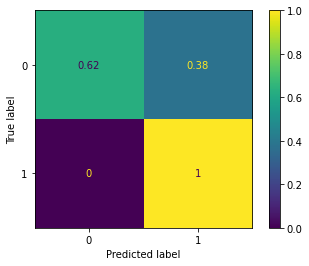

In [25]:
cm=confusion_matrix(y_test,preds,normalize="true")
cmd = ConfusionMatrixDisplay(cm)
cmd.plot()

# Interpretation: SHAP

Mean values 0.33561941156995945, 0.6643805914744735


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.


Image #0: True Class 1, Prediction 1, Probabilities tensor([[7.3855e-08, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


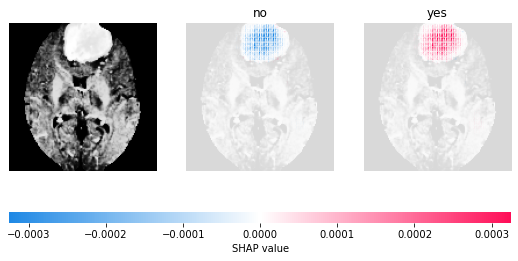

Image #1: True Class 0, Prediction 0, Probabilities tensor([[0.9722, 0.0278]], grad_fn=<SoftmaxBackward0>)


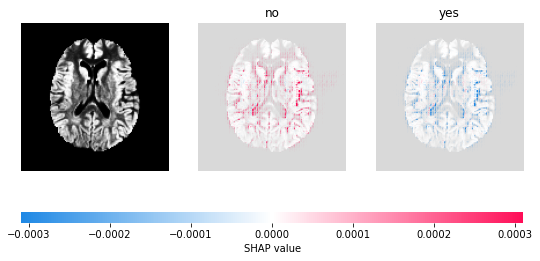

Image #2: True Class 1, Prediction 1, Probabilities tensor([[0.0508, 0.9492]], grad_fn=<SoftmaxBackward0>)


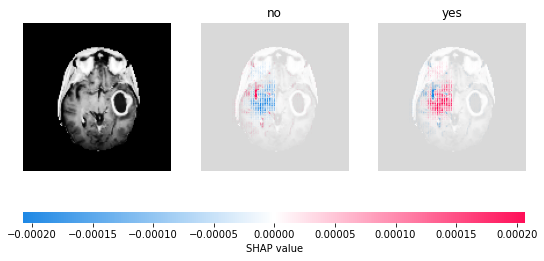

Image #3: True Class 1, Prediction 1, Probabilities tensor([[0.4031, 0.5969]], grad_fn=<SoftmaxBackward0>)


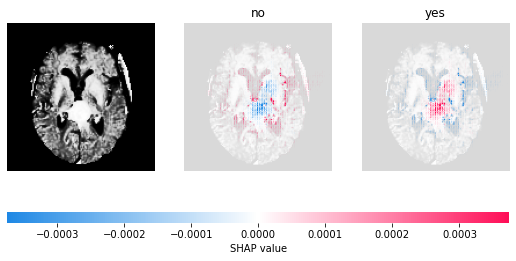

Image #4: True Class 0, Prediction 1, Probabilities tensor([[0.0133, 0.9867]], grad_fn=<SoftmaxBackward0>)


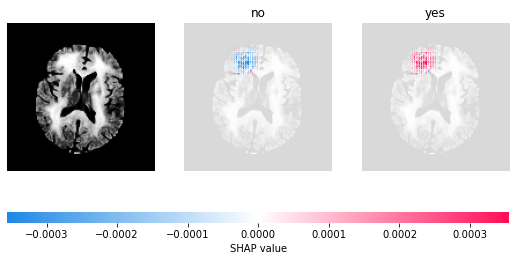

Image #5: True Class 1, Prediction 1, Probabilities tensor([[7.0870e-06, 9.9999e-01]], grad_fn=<SoftmaxBackward0>)


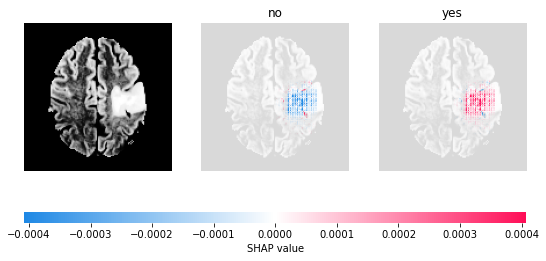

Image #6: True Class 1, Prediction 1, Probabilities tensor([[0.4931, 0.5069]], grad_fn=<SoftmaxBackward0>)


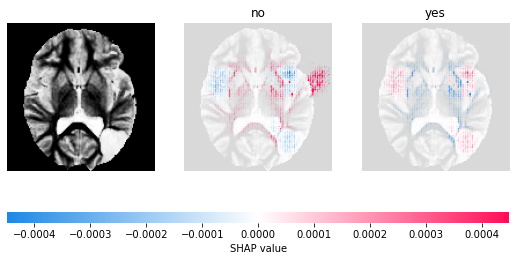

Image #7: True Class 1, Prediction 1, Probabilities tensor([[1.6251e-06, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


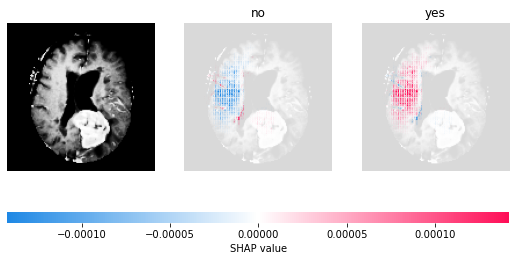

Image #8: True Class 1, Prediction 1, Probabilities tensor([[3.1691e-14, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


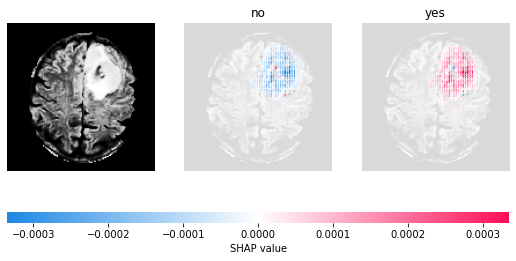

Image #9: True Class 1, Prediction 1, Probabilities tensor([[2.6735e-12, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)


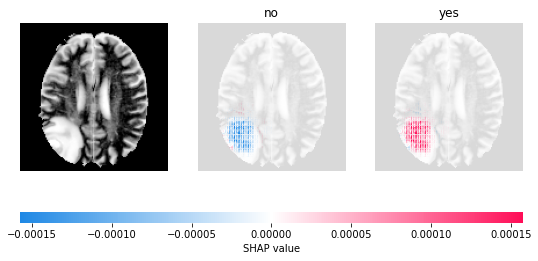

Image #10: True Class 1, Prediction 1, Probabilities tensor([[0.0142, 0.9858]], grad_fn=<SoftmaxBackward0>)


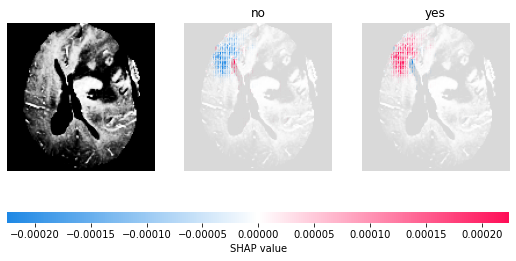

Image #11: True Class 0, Prediction 1, Probabilities tensor([[6.4378e-05, 9.9994e-01]], grad_fn=<SoftmaxBackward0>)


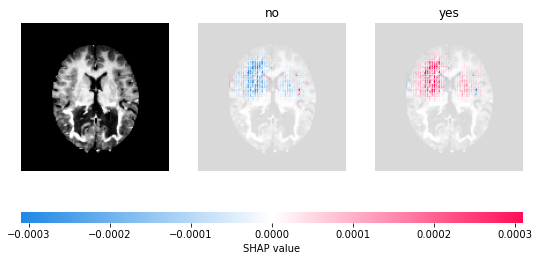

Image #12: True Class 0, Prediction 0, Probabilities tensor([[0.9606, 0.0394]], grad_fn=<SoftmaxBackward0>)


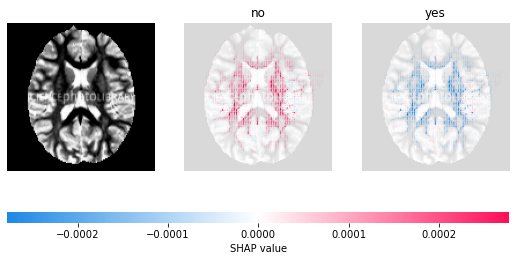

Image #13: True Class 1, Prediction 1, Probabilities tensor([[0.0185, 0.9815]], grad_fn=<SoftmaxBackward0>)


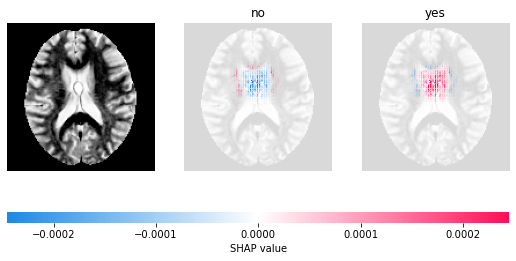

Image #14: True Class 1, Prediction 1, Probabilities tensor([[3.2860e-05, 9.9997e-01]], grad_fn=<SoftmaxBackward0>)


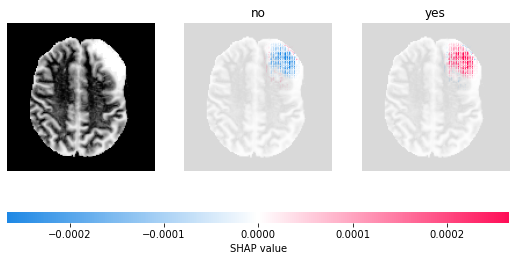

Image #15: True Class 0, Prediction 0, Probabilities tensor([[0.9736, 0.0264]], grad_fn=<SoftmaxBackward0>)


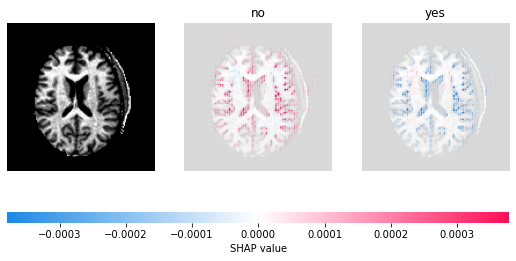

Image #16: True Class 1, Prediction 1, Probabilities tensor([[0.0253, 0.9747]], grad_fn=<SoftmaxBackward0>)


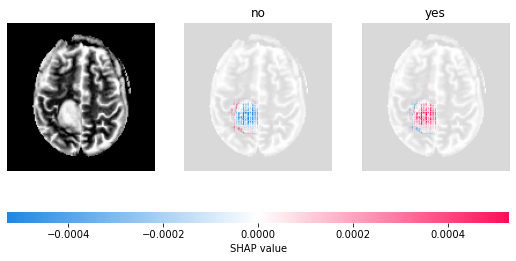

Image #17: True Class 0, Prediction 0, Probabilities tensor([[0.9792, 0.0208]], grad_fn=<SoftmaxBackward0>)


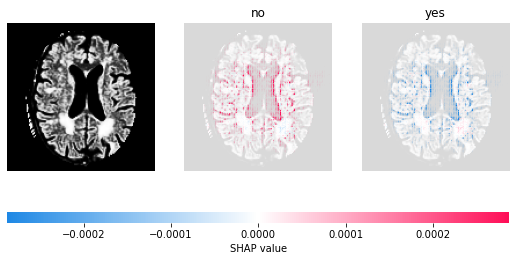

Image #18: True Class 0, Prediction 1, Probabilities tensor([[0.0038, 0.9962]], grad_fn=<SoftmaxBackward0>)


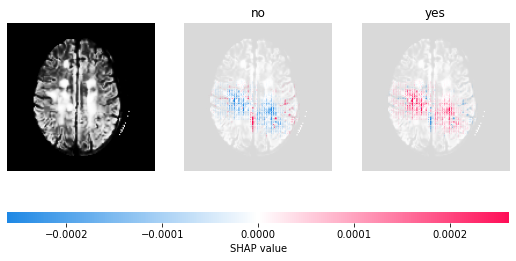

Image #19: True Class 0, Prediction 0, Probabilities tensor([[0.9680, 0.0320]], grad_fn=<SoftmaxBackward0>)


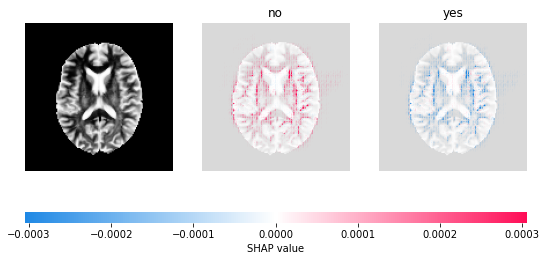

In [22]:
# Deep Explainer
np.random.seed(123)
indices = np.random.randint(0, high=len(train_dataset), size=100)
bg = torch.utils.data.Subset(train_dataset, indices)
bg = [i for i,j in bg]
bg = torch.stack(bg)

e = shap.DeepExplainer(model, bg)

outs = []
for i in bg:
    pred, out = predict(model,i)
    outs.append((out[0][0].item(), out[0][1].item()))
print(f"Mean values {np.mean([i for i,j in outs])}, {np.mean([j for i,j in outs])}")

test_images = [i for i,j in test_dataset]
y_test = [j for i,j in test_dataset]

for i, image in enumerate(test_images):
    
    image = image.reshape((1,1,128,128))
    pred, out = predict(model,image)
    shap_values = e.shap_values(image)
    shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
    test_numpy = np.swapaxes(np.swapaxes(image.cpu().numpy(), 1, -1), 1, 2)
    print(f"Image #{i}: True Class {y_test[i]}, Prediction {pred}, Probabilities {out}")
    shap.image_plot(shap_numpy, test_numpy, labels = ["no","yes"])

# GradCam